## Generate Synthetic Data
- This notebook demonstrates the code for generating synthetic datasets using sklearn.datasets.make_classification

In [1]:
import time
import warnings

import sys
sys.path.append('../')
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from itertools import cycle, islice
import os
from pipeline.utils import read_json, make_folder

In [3]:
def draw_scatter_plot(df, output_name_with_path):
    fig, ax = plt.subplots(1, figsize=(8, 6), dpi=220)
    groups = [1, 1, 0, 0]
    labels = [0, 1, 0, 1]
    markers = ['^', 'o', '^', 'o']
    colors = ['blue', 'blue', 'orange', 'orange']
    legends = ['majority + negative', 'majority + positive', 'minority + negative', 'minority + positive']

    for group_i, label_i, marker_i, color_i in zip(groups, labels, markers, colors):
        cur_df = df.query('A=={} and Y=={}'.format(group_i, label_i))

        plt.scatter(cur_df['X1'], cur_df['X2'], c=color_i, marker=marker_i, edgecolors=color_i, s=5, label='')
    plt.savefig(output_name_with_path, bbox_inches="tight") 
#     print('Scatter plot is saved at ', output_name_with_path)
#     plt.close()

In [4]:
def extract_y(x):
    if x > 1: # minority group, swap the label order
        return int(x*-1+3)
    else:
        return x
def extract_a(x):
    if x > 1: # minority group, swap the label order
        return 0
    else:
        return 1
    
def move_group_both_y(x, offsets, move_g):
    if x.iloc[1] == move_g: #  group 
        if x.iloc[2] == 0: # target label is negative
            return x.iloc[0] + offsets[0]
        else:
            return x.iloc[0] + offsets[1]
    else:
        return x.iloc[0]
    
def move_group_both_y_thresh(x, target_y, offset, move_g, thresh=None):
    if x.iloc[1] == move_g: #  group 
        if x.iloc[2] == target_y and x.iloc[2] > thresh: # target label is negative and 
            return x.iloc[0] + offset
        else:
            return x.iloc[0]
    else:
        return x.iloc[0]

In [5]:
repo_dir = sys.path[0].replace('notebooks', '')

data_path= repo_dir+ 'data/processed/'
plot_path = repo_dir + 'intermediate/plots/syn/'

make_folder(plot_path)

       X1    X2
A Y            
0 0  1500  1500
  1  1500  1500
1 0  4000  4000
  1  4000  4000


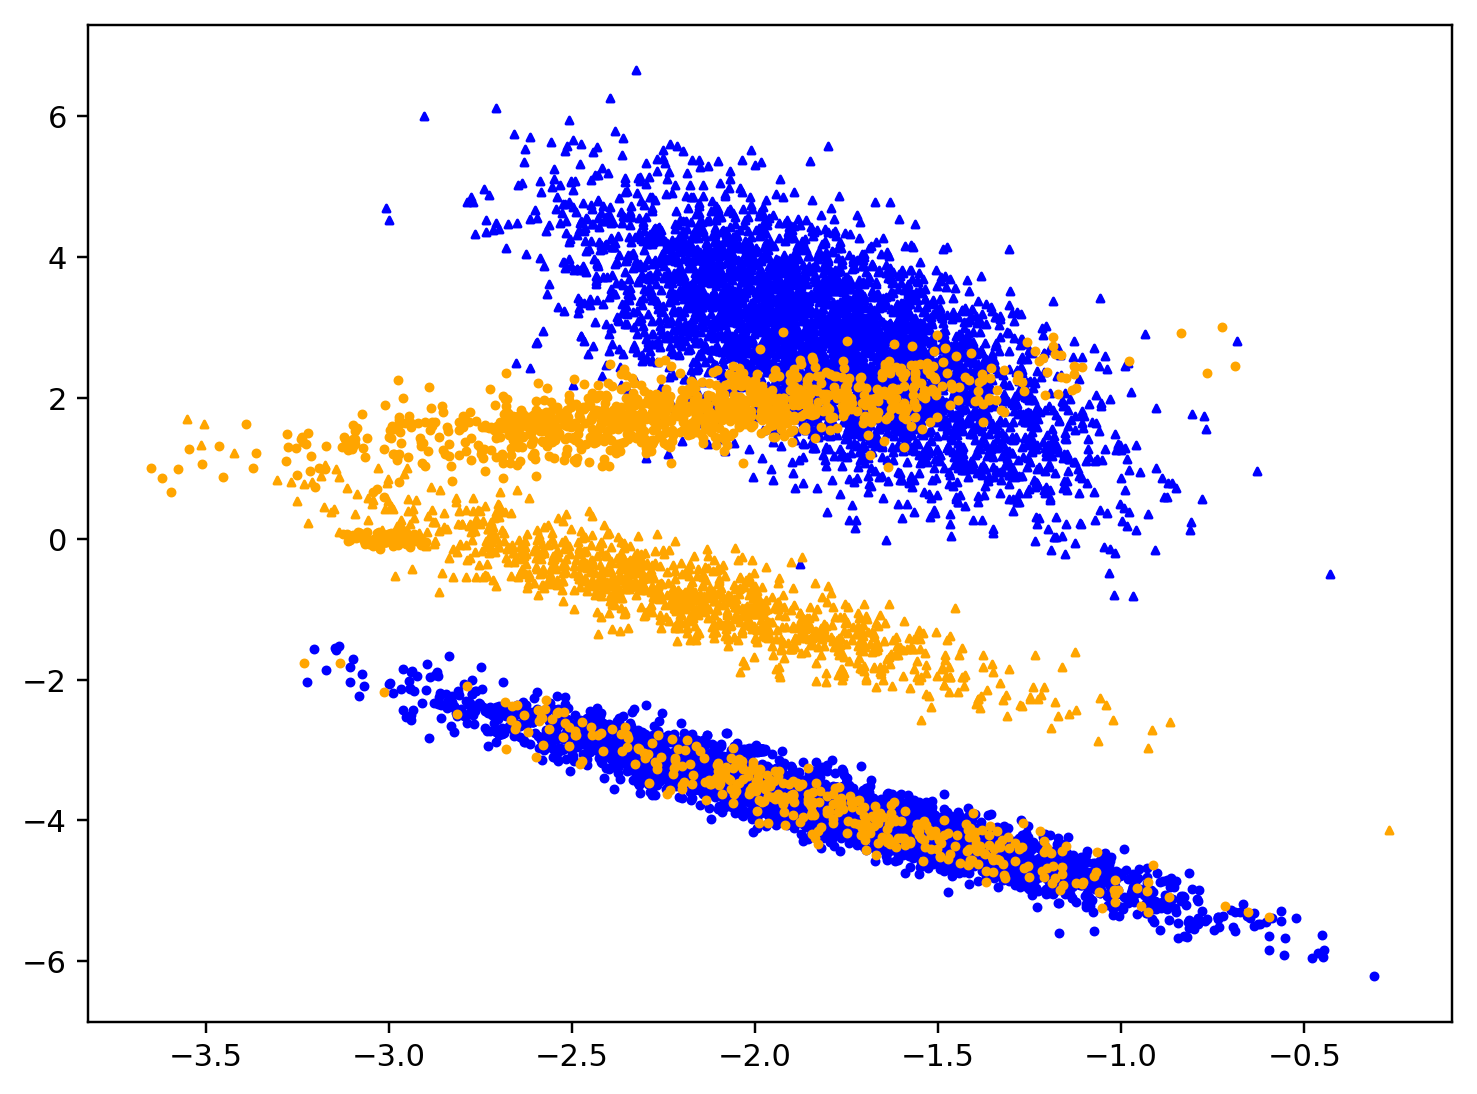

In [6]:
seed = 57005

# fixed parameters for make_classification
flip_a = 0.1
class_sep = 1.8
n_total = 10000
g_sizes = [0.4, 0.4, 0.1, 0.1] # [ma neg, ma pos, mi pos, mi neg]

# init output data
df = pd.DataFrame(columns=['X1', 'X2', 'Y', 'A']) 

# simulate the x and y for 4 classes
X2, Y2 = make_classification(n_samples=n_total, n_classes=len(g_sizes), n_features=2, n_redundant=0, n_informative=2, 
                             weights=g_sizes, flip_y=0,
                             class_sep=class_sep, n_clusters_per_class=1, random_state=seed)
df['X1'] = X2[:, 1]
df['X2'] = X2[:, 0]
df['Y'] = Y2

df['A'] = df['Y'].apply(lambda x: extract_a(x))
df['Y'] = df['Y'].apply(lambda x: extract_y(x))

# swap the Y to simulate smaller DI
df['Y'] = df['Y'].apply(lambda x: int(1-x))


#  move majority group outside the minority group
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [-4, -4], 0), axis=1)
df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [1, -2], 1), axis=1)

#  move minority group + positive label up to simulate lower DI 
df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [1, 0], 0), axis=1)


# simulate lower DI: add more A=0 and Y=1 inside A=0, where x2 centering at 0, x1 centering at -3.0 
df_pos_g0 = pd.DataFrame()
df_pos_g0['X1'] = np.random.normal(size=100, loc=-3.0, scale=0.05)
df_pos_g0['X2'] = np.random.normal(size=100, loc=0, scale=0.05)
df_pos_g0['Y'] = 1
df_pos_g0['A'] = 0
df = pd.concat([df, df_pos_g0])


# simulate mislabeled group membership by manually filpping 0.1 percentage of the majority to minority
df_i = df.query('A==1 and Y==1')
df_percent = df_i.sample(frac=flip_a, random_state=seed)
df.loc[df_percent.index, 'A'] = 0

# add same amount of A=1 Y=1 so that neg and pos is balanced inside A=1
df_pos_g1 = pd.DataFrame()
df_pos_g1['X1'] = np.random.normal(size=df_percent.shape[0], loc=-2.0, scale=0.01)
df_pos_g1['X2'] = np.random.normal(size=df_percent.shape[0], loc=-3.0, scale=0.01)
df_pos_g1['Y'] = 1
df_pos_g1['A'] = 1
df = pd.concat([df, df_pos_g1])

# add same amount of A=0 Y=0 so that neg and pos is balanced across dataset
df_neg_g0 = pd.DataFrame()
df_neg_g0['X1'] = np.random.normal(size=df_percent.shape[0]+100, loc=-2.0, scale=0.01)
df_neg_g0['X2'] = np.random.normal(size=df_percent.shape[0]+100, loc=-1.0, scale=0.01)
df_neg_g0['Y'] = 0
df_neg_g0['A'] = 0
df = pd.concat([df, df_neg_g0])

# save the data and plot into the disc
file_name = '{}seed{}.csv'.format(data_path, seed)
df.to_csv(file_name)

plot_name = '{}seed{}.png'.format(plot_path, seed)
draw_scatter_plot(df, plot_name)

print(df.groupby(by=['A','Y']).count())

       X1    X2
A Y            
0 0  1500  1500
  1  1500  1500
1 0  4000  4000
  1  4000  4000


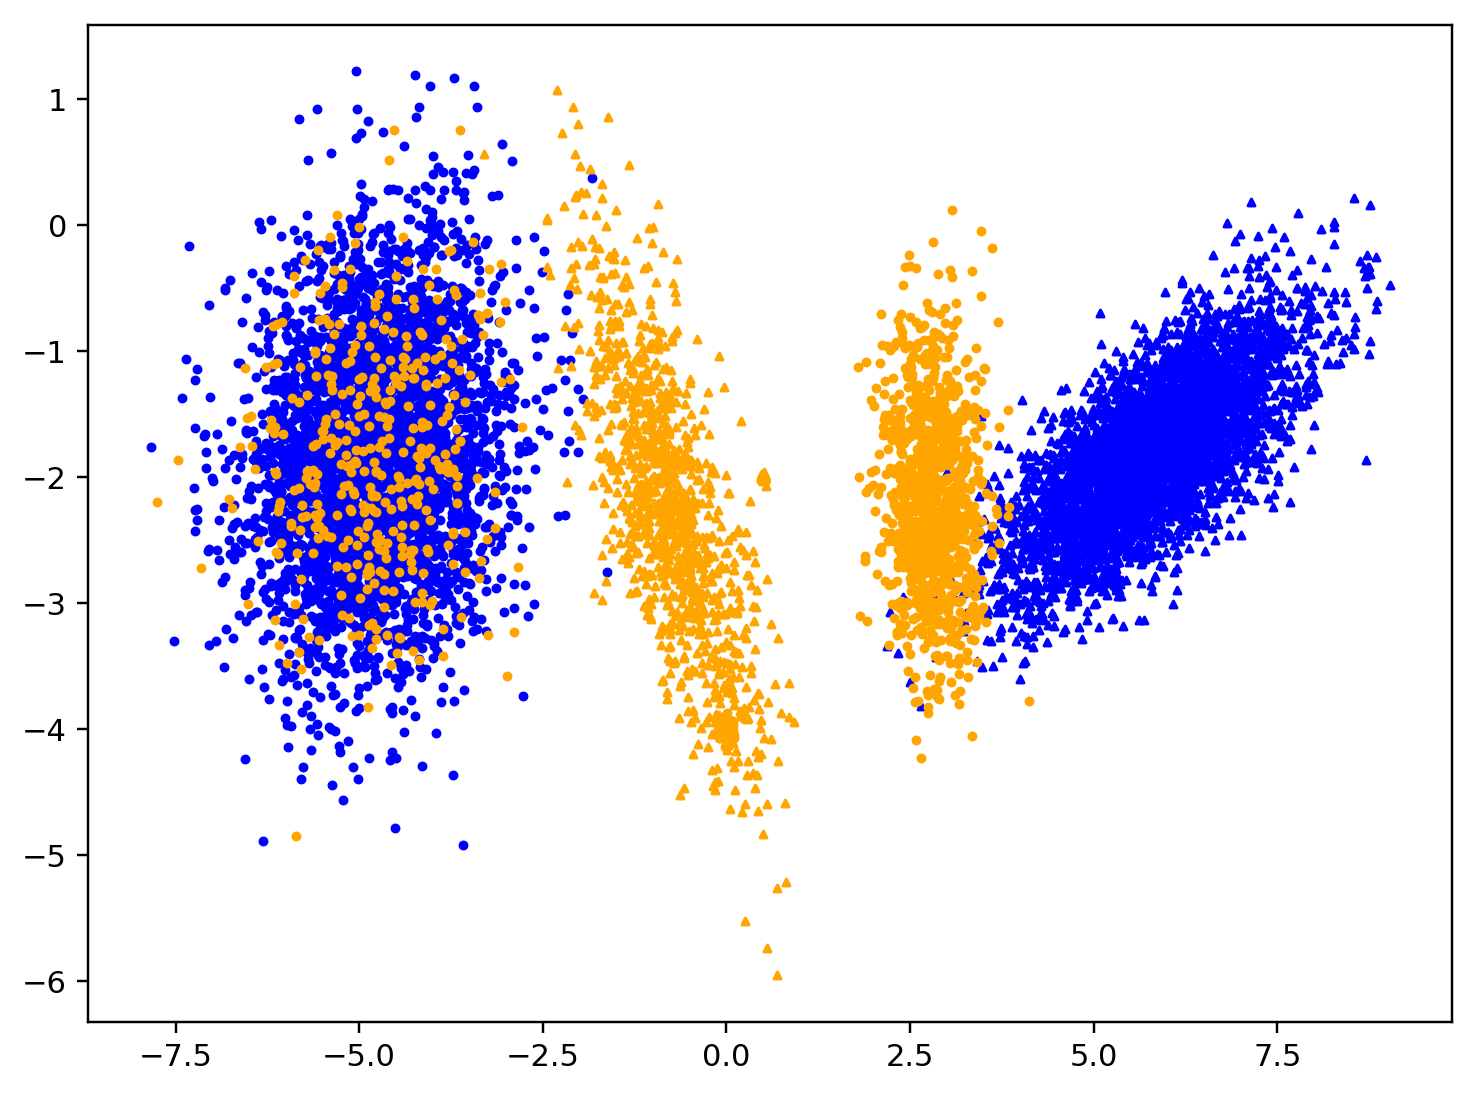

In [7]:
seed = 433

# init output data
df = pd.DataFrame(columns=['X1', 'X2', 'Y', 'A']) 

# simulate the x and y for 4 classes
X2, Y2 = make_classification(n_samples=n_total, n_classes=len(g_sizes), n_features=2, n_redundant=0, n_informative=2, 
                             weights=g_sizes, flip_y=0,
                             class_sep=class_sep, n_clusters_per_class=1, random_state=seed)
df['X1'] = X2[:, 1]
df['X2'] = X2[:, 0]
df['Y'] = Y2

df['A'] = df['Y'].apply(lambda x: extract_a(x))
df['Y'] = df['Y'].apply(lambda x: extract_y(x))

# swap the Y to simulate smaller DI
df['Y'] = df['Y'].apply(lambda x: int(1-x))

#  move majority group outside the minority group
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [4, -3], 1), axis=1)

df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [-4, -4], 0), axis=1)
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [1, 1], 0), axis=1)

# simulate lower DI: add more A=0 and Y=1 inside A=0, where x2 centering at -4, x1 centering at 0
df_pos_g0 = pd.DataFrame()
df_pos_g0['X1'] = np.random.normal(size=100, loc=0, scale=0.05)
df_pos_g0['X2'] = np.random.normal(size=100, loc=-4, scale=0.05)
df_pos_g0['Y'] = 1
df_pos_g0['A'] = 0
df = pd.concat([df, df_pos_g0])

# simulate mislabeled group membership by manually filpping 0.1 percentage of the majority to minority
df_i = df.query('A==1 and Y==1')
df_percent = df_i.sample(frac=flip_a, random_state=seed)
df.loc[df_percent.index, 'A'] = 0

# add same amount of A=1 Y=1 so that neg and pos is balanced inside A=1
df_pos_g1 = pd.DataFrame()
df_pos_g1['X1'] = np.random.normal(size=df_percent.shape[0], loc=-5.0, scale=0.01)
df_pos_g1['X2'] = np.random.normal(size=df_percent.shape[0], loc=-2.0, scale=0.01)
df_pos_g1['Y'] = 1
df_pos_g1['A'] = 1
df = pd.concat([df, df_pos_g1])

# add same amount of A=0 Y=0 so that neg and pos is balanced inside A=0 and across the entire dataset
df_neg_g0 = pd.DataFrame()
df_neg_g0['X1'] = np.random.normal(size=df_percent.shape[0]+100, loc=0.5, scale=0.01)
df_neg_g0['X2'] = np.random.normal(size=df_percent.shape[0]+100, loc=-2.0, scale=0.01)
df_neg_g0['Y'] = 0
df_neg_g0['A'] = 0
df = pd.concat([df, df_neg_g0])

# save the data and plot into the disc
file_name = '{}seed{}.csv'.format(data_path, seed)
df.to_csv(file_name)

plot_name = '{}seed{}.png'.format(plot_path, seed)
draw_scatter_plot(df, plot_name)

print(df.groupby(by=['A','Y']).count())

       X1    X2
A Y            
0 0  1500  1500
  1  1500  1500
1 0  4000  4000
  1  4000  4000


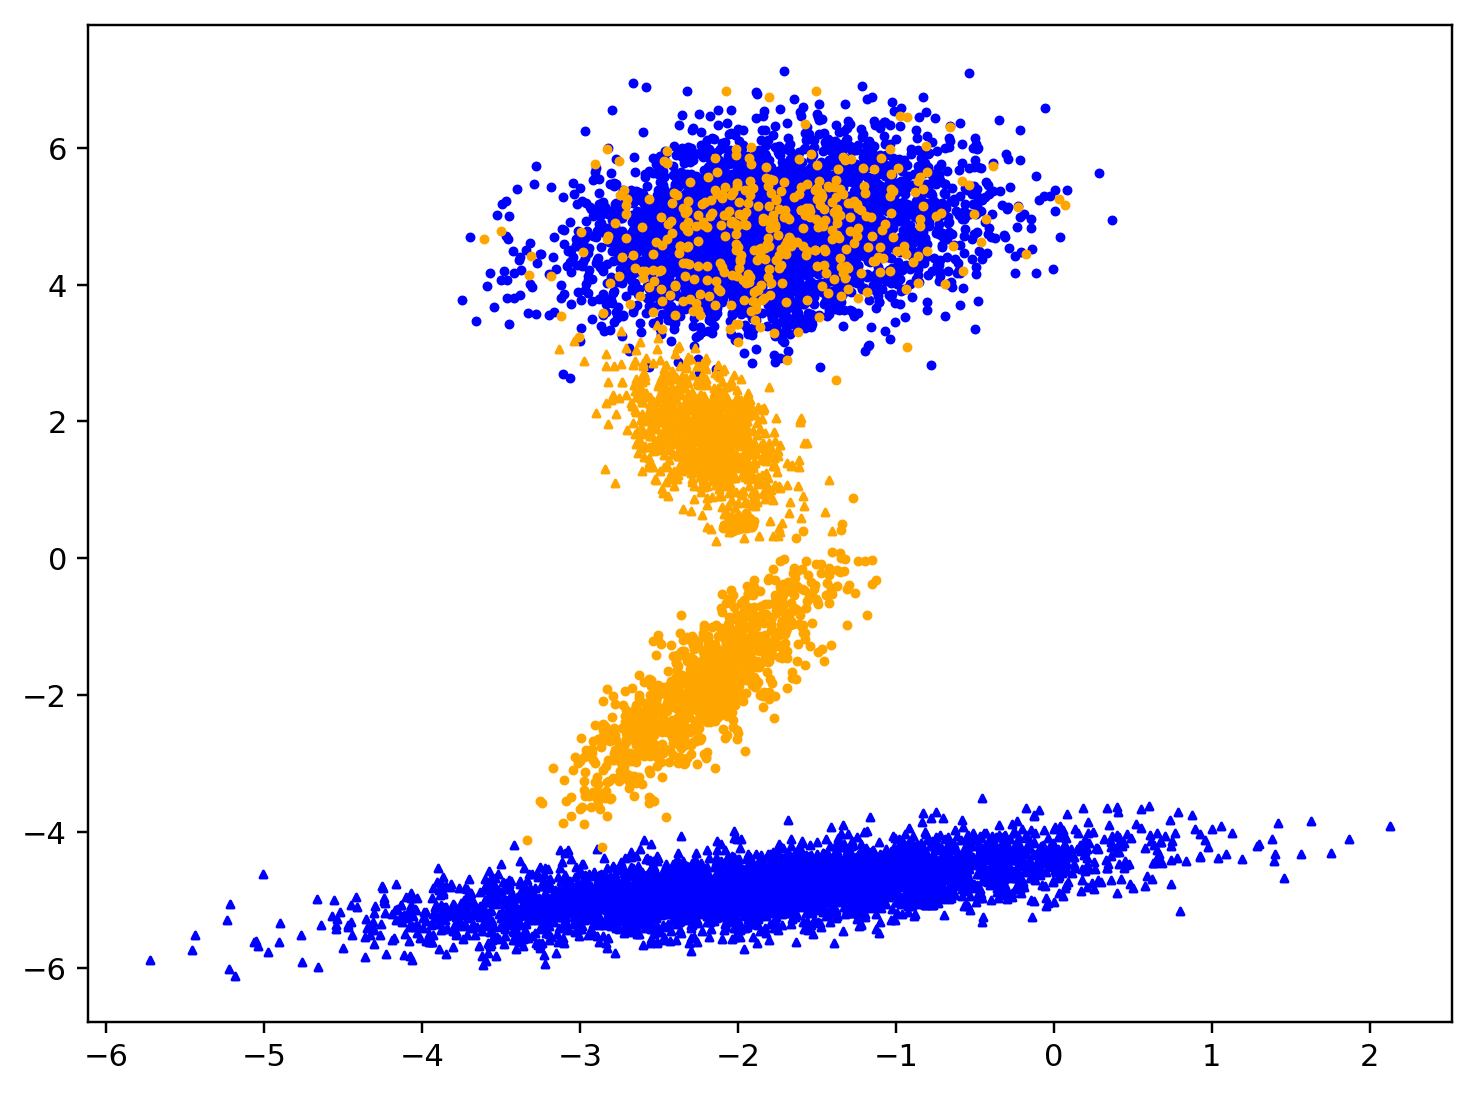

In [8]:
seed = 7777

# fixed parameters for make_classification
flip_a = 0.1
class_sep = 1.8
n_total = 10000
g_sizes = [0.4, 0.4, 0.1, 0.1] # [ma neg, ma pos, mi pos, mi neg]

# init output data
df = pd.DataFrame(columns=['X1', 'X2', 'Y', 'A']) 

# simulate the x and y for 4 classes
X2, Y2 = make_classification(n_samples=n_total, n_classes=len(g_sizes), n_features=2, n_redundant=0, n_informative=2, 
                             weights=g_sizes, flip_y=0,
                             class_sep=class_sep, n_clusters_per_class=1, random_state=seed)
df['X1'] = X2[:, 0]
df['X2'] = X2[:, 1]
df['Y'] = Y2

df['A'] = df['Y'].apply(lambda x: extract_a(x))
df['Y'] = df['Y'].apply(lambda x: extract_y(x))

# swap the Y to simulate smaller DI
# df['Y'] = df['Y'].apply(lambda x: int(1-x))

#  move majority group outside the minority group
df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [-3, 3], 1), axis=1)

# # df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [-4, -4], 0), axis=1)
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [-4, -4], 0), axis=1)

# simulate lower DI: add more A=0 and Y=1 inside A=0, such that there are some points with Y=1 close to Y=0 inside A=0
df_pos_g0 = pd.DataFrame()
df_pos_g0['X1'] = np.random.normal(size=100, loc=-2, scale=0.05)
df_pos_g0['X2'] = np.random.normal(size=100, loc=0.5, scale=0.05)
df_pos_g0['Y'] = 1
df_pos_g0['A'] = 0
df = pd.concat([df, df_pos_g0])

# simulate mislabeled group membership by manually filpping 0.1 percentage of the majority to minority
df_i = df.query('A==1 and Y==1')
df_percent = df_i.sample(frac=flip_a, random_state=seed)
df.loc[df_percent.index, 'A'] = 0

# add same amount of A=1 Y=1 so that neg and pos is balanced inside A=1
df_pos_g1 = pd.DataFrame()
df_pos_g1['X1'] = np.random.normal(size=df_percent.shape[0], loc=-2.0, scale=0.01)
df_pos_g1['X2'] = np.random.normal(size=df_percent.shape[0], loc=5, scale=0.01)
df_pos_g1['Y'] = 1
df_pos_g1['A'] = 1
df = pd.concat([df, df_pos_g1])

# add same amount of A=0 Y=0 so that neg and pos is balanced inside A=0 and across the entire dataset
df_neg_g0 = pd.DataFrame()
df_neg_g0['X1'] = np.random.normal(size=df_percent.shape[0]+100, loc=-2, scale=0.01)
df_neg_g0['X2'] = np.random.normal(size=df_percent.shape[0]+100, loc=2, scale=0.01)
df_neg_g0['Y'] = 0
df_neg_g0['A'] = 0
df = pd.concat([df, df_neg_g0])

# save the data and plot into the disc
file_name = '{}seed{}.csv'.format(data_path, seed)
df.to_csv(file_name)

plot_name = '{}seed{}.png'.format(plot_path, seed)
draw_scatter_plot(df, plot_name)

print(df.groupby(by=['A','Y']).count())

       X1    X2
A Y            
0 0  1500  1500
  1  1500  1500
1 0  4000  4000
  1  4000  4000


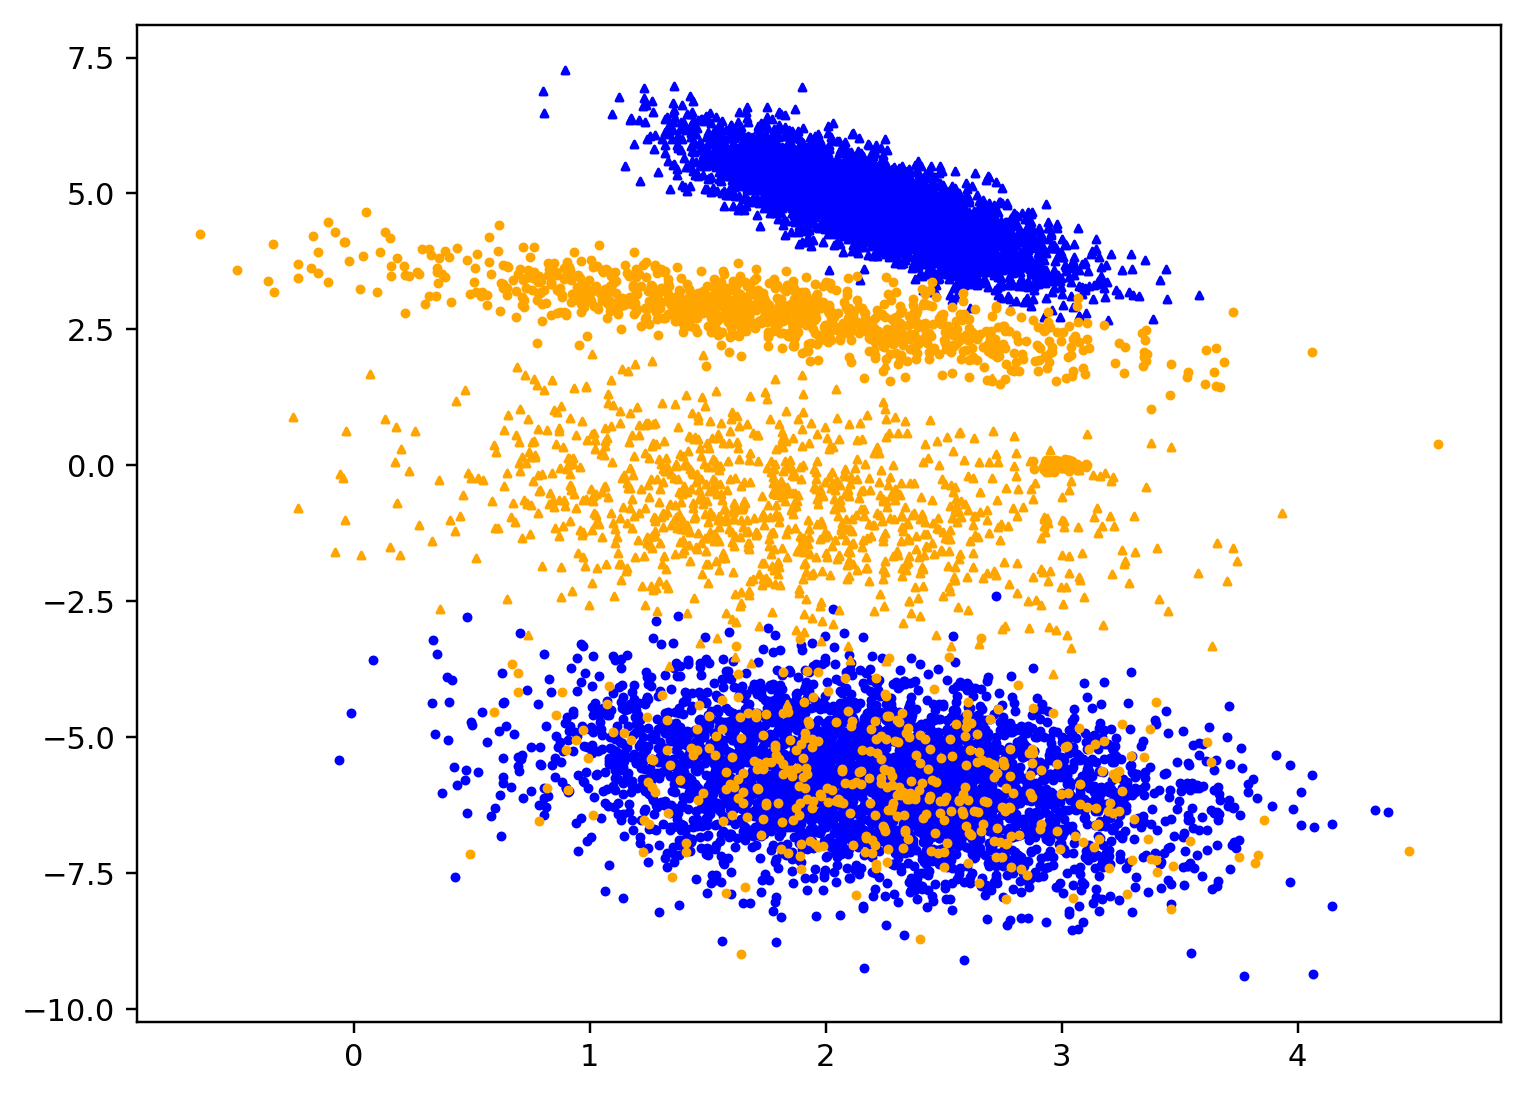

In [9]:
seed = 12345

# fixed parameters for make_classification
flip_a = 0.1
class_sep = 1.8
n_total = 10000
g_sizes = [0.4, 0.4, 0.1, 0.1] # [ma neg, ma pos, mi pos, mi neg]

# init output data
df = pd.DataFrame(columns=['X1', 'X2', 'Y', 'A']) 

# simulate the x and y for 4 classes
X2, Y2 = make_classification(n_samples=n_total, n_classes=len(g_sizes), n_features=2, n_redundant=0, n_informative=2, 
                             weights=g_sizes, flip_y=0,
                             class_sep=class_sep, n_clusters_per_class=1, random_state=seed)
df['X1'] = X2[:, 1]
df['X2'] = X2[:, 0]
df['Y'] = Y2

df['A'] = df['Y'].apply(lambda x: extract_a(x))
df['Y'] = df['Y'].apply(lambda x: extract_y(x))

# swap the Y to simulate smaller DI
df['Y'] = df['Y'].apply(lambda x: int(1-x))

# # #  move majority group outside the minority group
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [4, 4], 1), axis=1)
df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [3, -4], 1), axis=1)

df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [1, 1], 0), axis=1)

# simulate lower DI: add more A=0 and Y=1 inside A=0, such that there are some points with Y=1 close to Y=0 inside A=0
df_pos_g0 = pd.DataFrame()
df_pos_g0['X1'] = np.random.normal(size=100, loc=3, scale=0.05)
df_pos_g0['X2'] = np.random.normal(size=100, loc=0, scale=0.05)
df_pos_g0['Y'] = 1
df_pos_g0['A'] = 0
df = pd.concat([df, df_pos_g0])

# simulate mislabeled group membership by manually filpping 0.1 percentage of the majority to minority
df_i = df.query('A==1 and Y==1')
df_percent = df_i.sample(frac=flip_a, random_state=seed)
df.loc[df_percent.index, 'A'] = 0

# add same amount of A=1 Y=1 so that neg and pos is balanced inside A=1
df_pos_g1 = pd.DataFrame()
df_pos_g1['X1'] = np.random.normal(size=df_percent.shape[0], loc=2, scale=0.01)
df_pos_g1['X2'] = np.random.normal(size=df_percent.shape[0], loc=-5, scale=0.01)
df_pos_g1['Y'] = 1
df_pos_g1['A'] = 1
df = pd.concat([df, df_pos_g1])

# add same amount of A=0 Y=0 so that neg and pos is balanced inside A=0 and across the entire dataset
df_neg_g0 = pd.DataFrame()
df_neg_g0['X1'] = np.random.normal(size=df_percent.shape[0]+100, loc=1.8, scale=0.01)
df_neg_g0['X2'] = np.random.normal(size=df_percent.shape[0]+100, loc=-0.5, scale=0.01)
df_neg_g0['Y'] = 0
df_neg_g0['A'] = 0
df = pd.concat([df, df_neg_g0])

# save the data and plot into the disc
file_name = '{}seed{}.csv'.format(data_path, seed)
df.to_csv(file_name)

plot_name = '{}seed{}.png'.format(plot_path, seed)
draw_scatter_plot(df, plot_name)

print(df.groupby(by=['A','Y']).count())

       X1    X2
A Y            
0 0  1500  1500
  1  1500  1500
1 0  4000  4000
  1  4000  4000


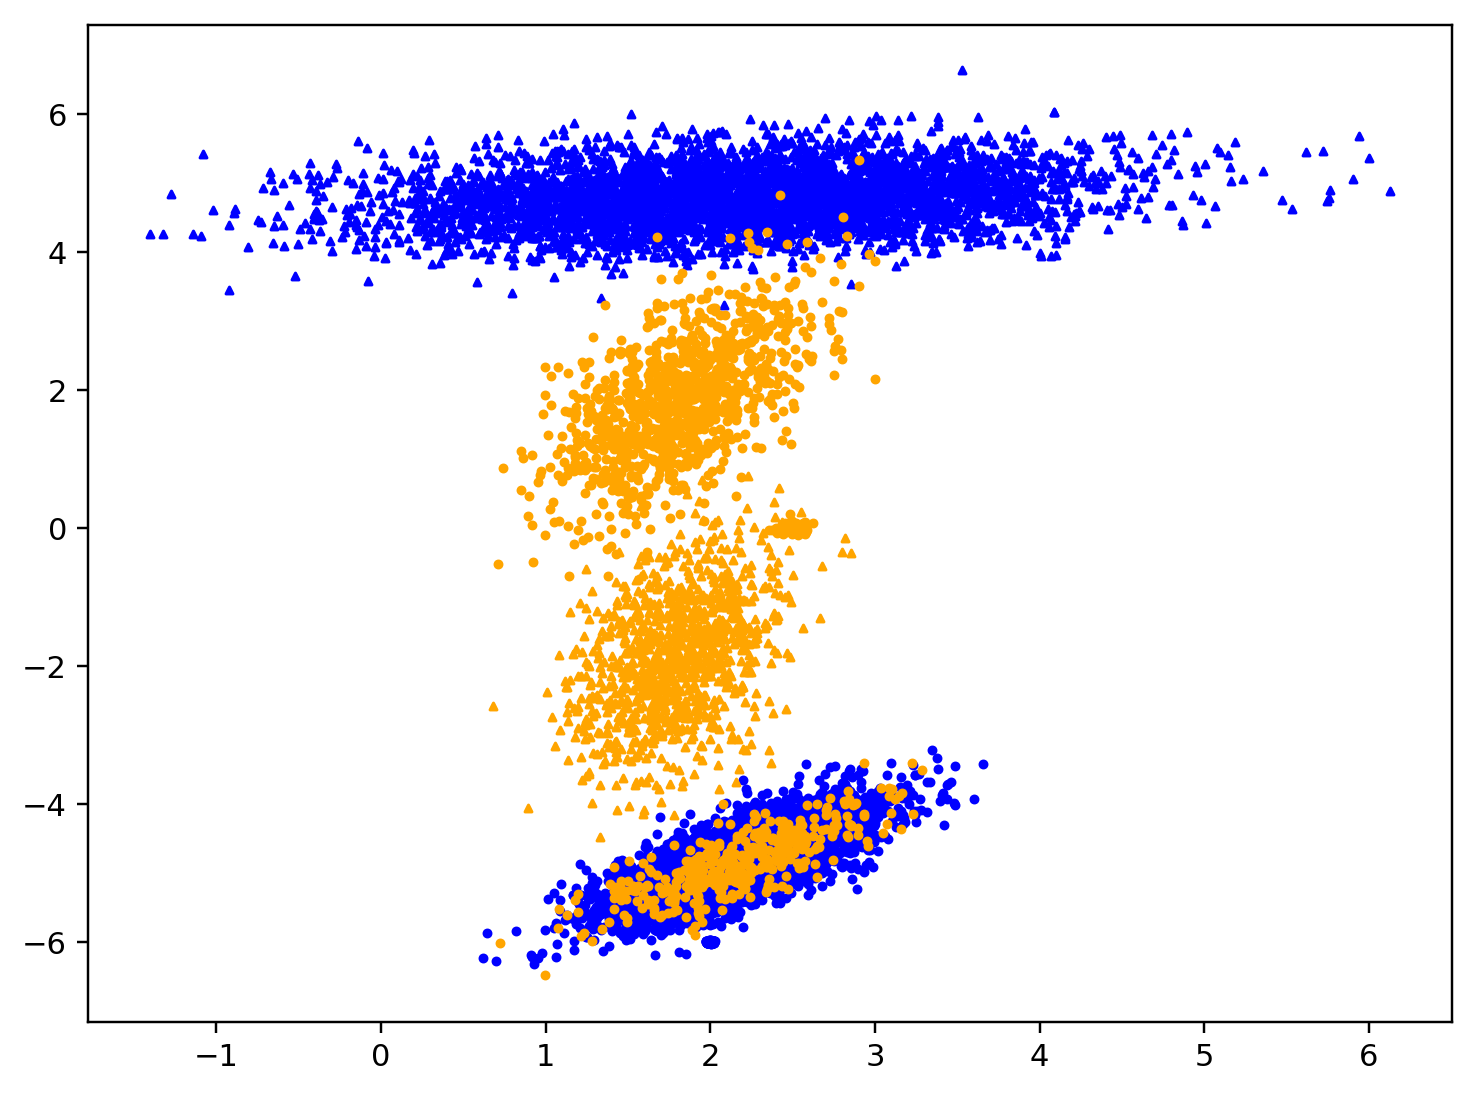

In [10]:
seed = 15

# fixed parameters for make_classification
flip_a = 0.1
class_sep = 1.8
n_total = 10000
g_sizes = [0.4, 0.4, 0.1, 0.1] # [ma neg, ma pos, mi pos, mi neg]

# init output data
df = pd.DataFrame(columns=['X1', 'X2', 'Y', 'A']) 

# simulate the x and y for 4 classes
X2, Y2 = make_classification(n_samples=n_total, n_classes=len(g_sizes), n_features=2, n_redundant=0, n_informative=2, 
                             weights=g_sizes, flip_y=0,
                             class_sep=class_sep, n_clusters_per_class=1, random_state=seed)
df['X1'] = X2[:, 1]
df['X2'] = X2[:, 0]
df['Y'] = Y2

df['A'] = df['Y'].apply(lambda x: extract_a(x))
df['Y'] = df['Y'].apply(lambda x: extract_y(x))

# swap the Y to simulate smaller DI
df['Y'] = df['Y'].apply(lambda x: int(1-x))

# # #  move majority group outside the minority group
df['X1'] = df[['X1', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [4, 4], 1), axis=1)
df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [3, -3], 1), axis=1)

# df['X2'] = df[['X2', 'A', 'Y']].apply(lambda x: move_group_both_y(x, [1, 0], 0), axis=1)

# simulate lower DI: add more A=0 and Y=1 inside A=0, such that there are some points with Y=1 close to Y=0 inside A=0
df_pos_g0 = pd.DataFrame()
df_pos_g0['X1'] = np.random.normal(size=100, loc=2.5, scale=0.05)
df_pos_g0['X2'] = np.random.normal(size=100, loc=0, scale=0.05)
df_pos_g0['Y'] = 1
df_pos_g0['A'] = 0
df = pd.concat([df, df_pos_g0])

# simulate mislabeled group membership by manually filpping 0.1 percentage of the majority to minority
df_i = df.query('A==1 and Y==1')
df_percent = df_i.sample(frac=flip_a, random_state=seed)
df.loc[df_percent.index, 'A'] = 0

# add same amount of A=1 Y=1 so that neg and pos is balanced inside A=1
df_pos_g1 = pd.DataFrame()
df_pos_g1['X1'] = np.random.normal(size=df_percent.shape[0], loc=2, scale=0.01)
df_pos_g1['X2'] = np.random.normal(size=df_percent.shape[0], loc=-6, scale=0.01)
df_pos_g1['Y'] = 1
df_pos_g1['A'] = 1
df = pd.concat([df, df_pos_g1])

# add same amount of A=0 Y=0 so that neg and pos is balanced inside A=0 and across the entire dataset
df_neg_g0 = pd.DataFrame()
df_neg_g0['X1'] = np.random.normal(size=df_percent.shape[0]+100, loc=1.8, scale=0.01)
df_neg_g0['X2'] = np.random.normal(size=df_percent.shape[0]+100, loc=-2, scale=0.01)
df_neg_g0['Y'] = 0
df_neg_g0['A'] = 0
df = pd.concat([df, df_neg_g0])

# save the data and plot into the disc
file_name = '{}seed{}.csv'.format(data_path, seed)
df.to_csv(file_name)

plot_name = '{}seed{}.png'.format(plot_path, seed)
draw_scatter_plot(df, plot_name)

print(df.groupby(by=['A','Y']).count())